#### Import

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, Lars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from scipy.stats import norm
from datetime import datetime
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz
from decimal import Decimal, getcontext
from sklearn.linear_model import LinearRegression


#### Aux Functions

In [ ]:
def threshold_remove(data,coef,target,threshold = 0.1,axis=1):
    #Iterate through all terms and force to 0 the ones which does not change the norm of the matrix more than the threshold
    for i in range(len(coef)):
        coef_ = np.delete(coef,i,axis=0)
        data_ = np.delete(data,i,axis=axis)
        matrix_org = data @ coef
        matrix_tg = data_ @ coef_
        if np.abs(np.linalg.norm(matrix_tg) - np.linalg.norm(matrix_org))/np.linalg.norm(matrix_org) < threshold:
            coef[i] = 0. 
    # Optimize the coefficients of the remaining terms
    idx_not_null = np.where(coef)
    data_ = data_[:,:,idx_not_null[0]]
    x = np.reshape(data_,(data_.shape[0]*data_.shape[1],data_.shape[2]))
    y = np.ravel(target)
    c, r, rank, s = np.linalg.lstsq(x, y, rcond=None)
    coef[idx_not_null] = c
    return coef

In [ ]:
def print_model(coefs:list,var_names:list):
    eq = 'u_t ='
    for coef,var in zip(coefs, var_names):
        if coef != 0:
            eq += ' + ' + "{:.3f}".format(coef) + ' ' + var
    print(eq)

#### SPY options

In [85]:
calls=pd.read_csv('data/calls.csv')
puts=pd.read_csv('data/puts.csv')
underlying=pd.read_csv('data/underlying_data.csv')

calls.index=calls[calls.columns[0]]
calls=calls.drop(columns=calls.columns[0])

puts.index=puts[puts.columns[0]]
puts=puts.drop(columns=puts.columns[0])

underlying.index=underlying[underlying.columns[0]]
underlying=underlying.drop(columns=underlying.columns[0])

In [86]:
calls['underlying']=underlying['price']
calls.index=[datetime.strptime(i,"%Y-%m-%d") for i in calls.index]
calls['time_to_exp']=[(datetime(2022,9,30)-i).days/365 for i in calls.index]
calls=calls[calls['time_to_exp']<0.9]
calls=calls.sort_index()[::]


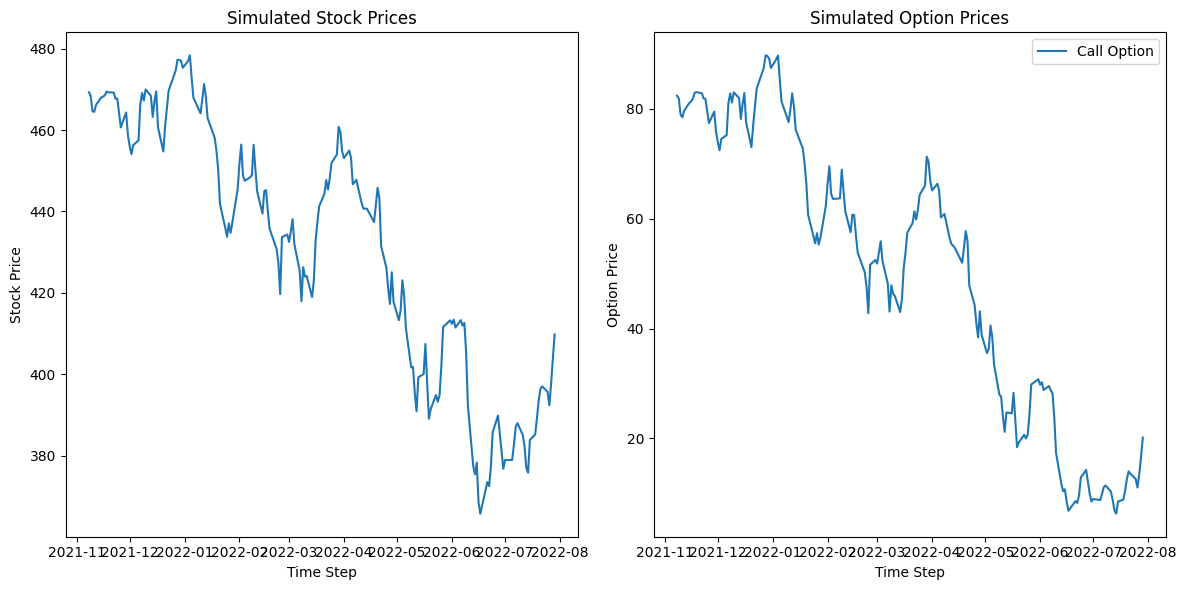

In [87]:
# Plot the simulated stock prices and option prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(calls['underlying'])
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

plt.subplot(1, 2, 2)
plt.plot(calls['price'], label='Call Option')
# plt.plot(option_prices_put, label='Put Option')
plt.title('Simulated Option Prices')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.legend()

plt.tight_layout()
plt.show()

In [88]:
u = np.real(calls['price'])
t = np.ravel(calls['time_to_exp'])
x = np.ravel(calls['underlying'])
timesteps = len(t)
spacesteps = len(x)


dt = t[1] - t[0]
dx = x[1] - x[0]
# u_dot =  ps.FiniteDifference(axis=0)._differentiate(x= C,t=dt)
# dt = 1
# dt = ps.FiniteDifference(axis=0)._differentiate(x= t,t=1)

Text(0.5, 1.0, '$\\hat{u}(x, t)$')

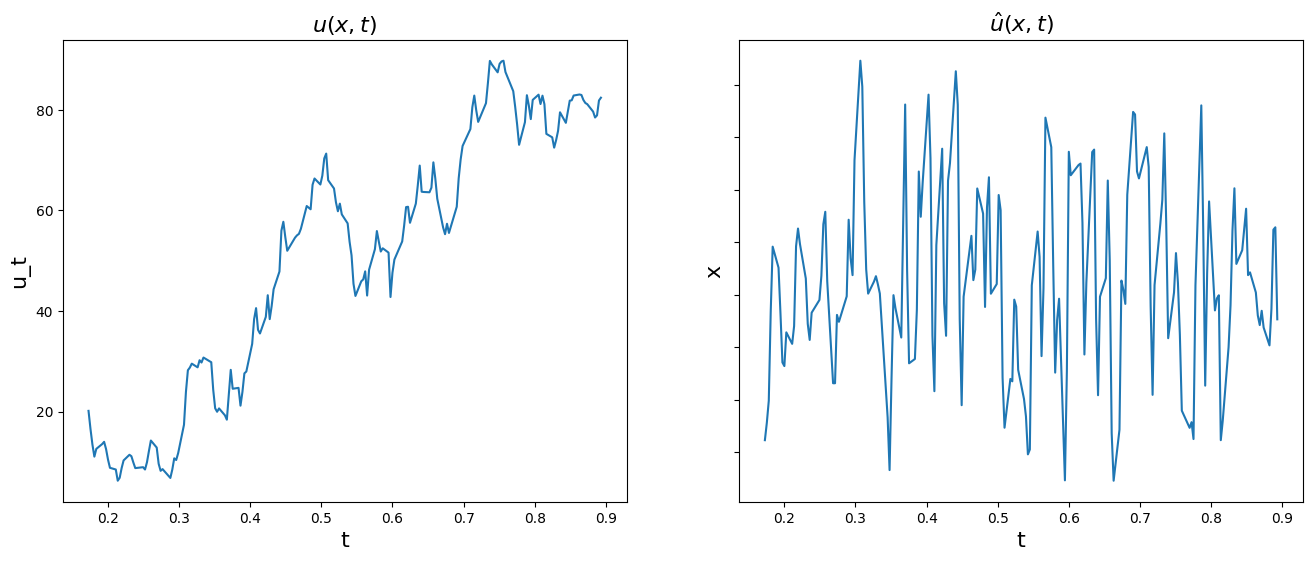

In [89]:
# n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(axis=0,order = 2)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(u,t = dx)
u_t = ps.FiniteDifference(axis=0,order = 2)._differentiate(u,t = dt)
# v_dot = numerical_partial_black_scholes(u.T,r,sigma).T

# Plot u and u_dot
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(t, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("u_t", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
# plt.colorbar(orientation="horizontal")

# plt.subplot(3, 2, 5)
# plt.pcolormesh(t, x, v_dot)
# plt.xlabel("t", fontsize=16)
# plt.ylabel("x", fontsize=16)
# ax = plt.gca()
# ax.set_yticklabels([])
# plt.title(r"$\hat{\hat{\hat{u}}}(x, t)$ from DURA-MOS¸NEAGU", fontsize=16)
# plt.colorbar(orientation="horizontal")

# u_dot = -(1/2)*((sigma**2)*(X.T**2)*u_xx) - (r*(X.T)*u_x) + r*u
plt.subplot(1, 2, 2)
plt.plot(t, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{u}(x, t)$", fontsize=16)

##### PySINDy

In [ ]:
u = np.reshape(u, (*u.shape, 1))
u_xx  = np.reshape(u_xx, (*u_xx.shape, 1))
u_x   = np.reshape(u_x, (*u_x.shape, 1))
# v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
# spatial_grid = np.reshape(X.T, (len(x), len(t), 1))
spatial_grid = np.reshape(x, (*x.shape,1))

In [93]:
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=False,
    periodic=False # uniformly sampled in time
)

u_final = u
u_final = np.concatenate((u_final,u_x,u_xx,spatial_grid,spatial_grid**2),axis=1)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
lib_tr = lib.fit_transform(u_final)

In [100]:
print('----------------------------Finite Difference--------------------------------')
print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=7e-3, alpha=1e-1)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final)

print('\nMean threshold remove \n')
new_coef = threshold_remove(lib_tr,model.coefficients()[0],threshold = 0.5,axis=1)
pred = lib_tr @ new_coef
print_model(new_coef,lib.get_feature_names())



print('*'*50)

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=7e-3, alpha=1e-1)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final, x_dot = u_t,
        library_ensemble =True, 
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(t) // 2,
        ensemble_aggregator = lambda x: np.mean(x*100, axis=0),
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print_model(mean_ensemble,lib.get_feature_names())

print_model(median_ensemble,lib.get_feature_names())

print('Error Model prediction against analytical solution:')
optimizer.coef_ = mean_ensemble
pred = model.predict(u_final)

print('\nMean threshold remove \n')
new_coef = threshold_remove(lib_tr,median_ensemble,threshold = 0.5,axis=1)
pred = lib_tr @ new_coef
print_model(new_coef,lib.get_feature_names())


----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = 352.225 u_x
Error Model prediction against analytical solution:

Mean threshold remove 

u_t = + 352.225 u_x
**************************************************
----------------------------Ensemble method----------------------------
u_t = + -0.004 u + 183.139 u_x + 0.095 u_xx + 0.001 x + -0.520 u*u_x + -0.001 u*u_xx + 0.111 u_x*u_xx + 0.452 u_x*x
u_t = + 170.473 u_x + 0.078 u_xx + -0.561 u*u_x + 0.126 u_x*u_xx + 0.486 u_x*x
Error Model prediction against analytical solution:

Mean threshold remove 

u_t = + 170.473 u_x + -0.561 u*u_x + 0.486 u_x*x



#### Synthetic Option

In [4]:

def black_scholes_call_time_(S,K,T,r,sigma):
    '''
    Generate the values of the black scholes equation differentiate with respect to time
    '''
    d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
    call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt(T))) * norm.pdf(d1)
    return call_time

def black_scholes_call(S, X, T, r, sigma):
    '''
    Generate the price of an option through the black scholes equation
    '''
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def numerical_partial_black_scholes(V,r,sigma):
    '''
    Numerical calculation of the black-scholes through DURA-MOS¸NEAGU
    '''
    N = len(V[0])
    M = len(V[:,0])
    V_dot = np.zeros([M,N])

    alpha = 0.5*(sigma**2)
    beta = 0.5*r

    #Calculate option-value
    for m in range(M):
        v_m = []
        for n in range(1,N-1):
                v_m.append((beta*n - alpha*(n**2))*V[m,n-1] + 2*(beta + alpha*(n**2))*V[m,n] - (alpha*(n**2) + beta*n)*V[m,n+1])
        V_dot[m] = [0] + v_m + [0]
    return V_dot

In [5]:
# Constants
r = 0.05
sigma = 0.4
K = 105
T = 1.

timesteps = 1200
spacesteps =  110

# Monte Carlo simulation
x = np.linspace(0., K*3, spacesteps)
t = np.linspace(0, T, timesteps)
X, T = np.meshgrid(x, t)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K, tal, r, sigma)

# u is the call_prices array
u = call_prices.T

u_t = black_scholes_call_time_(X, K, tal, r, sigma).T[:,:-1]

C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_7692\1433584931.py:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_7692\1433584931.py:7: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_7692\1433584931.py:8: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_7692\1433584931.py:8: RuntimeWarning: divide by zero encountered in divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_7692\1433584931.py:2: RuntimeWarning: divide by zero encountered in divide
  d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
C:\Users\Bruno Trot

Error for Finite Difference 
RSE 0.0013233404779777838
RMSE 67.52886146041782
Error for Numerical Black-Scholes
RSE 0.0013574455314168503
RMSE 68.39350097343156


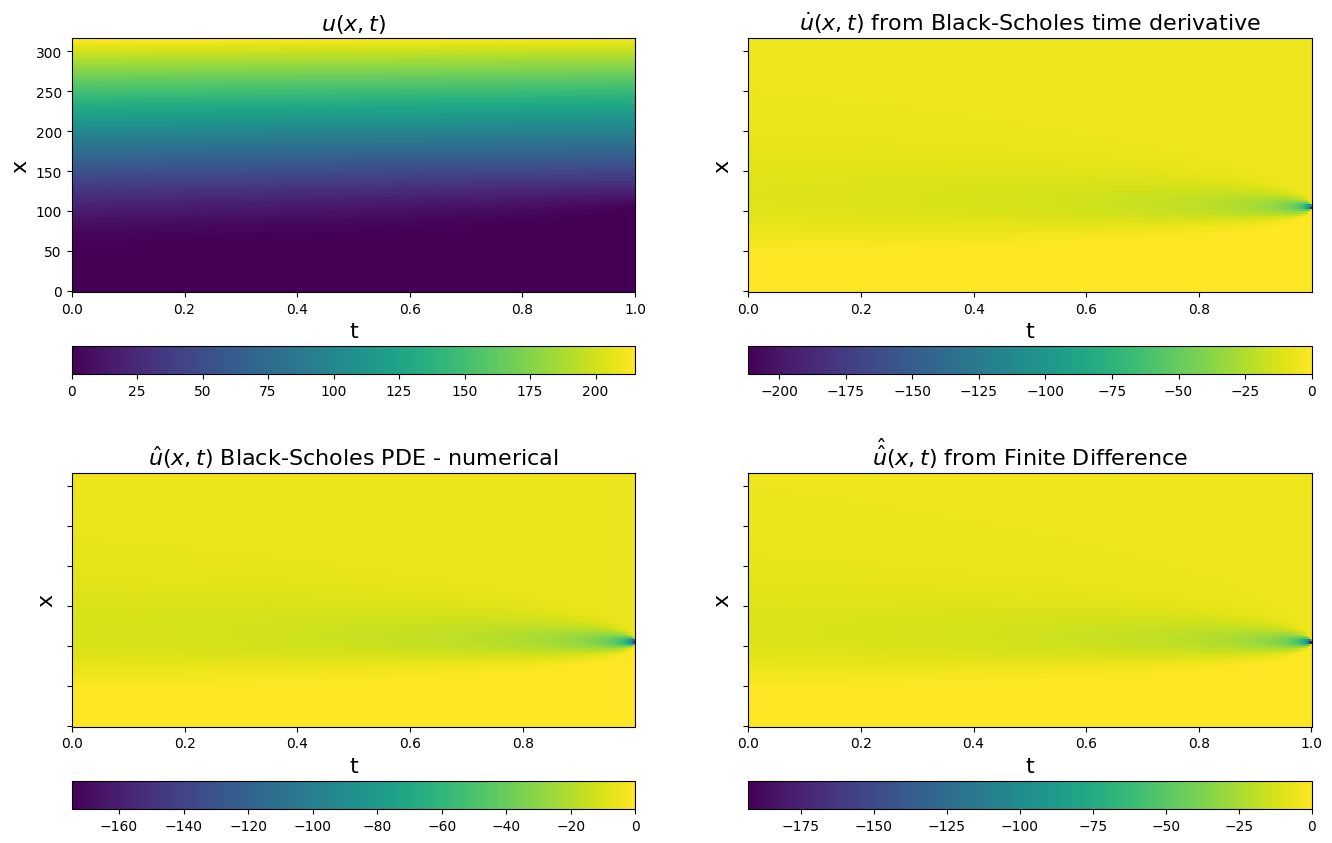

In [6]:
# n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(axis=0,order = 2)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(u,t = dx)
u_t_ = ps.FiniteDifference(axis=1,order = 1)._differentiate(u,t = dt)
# v_dot = numerical_partial_black_scholes(u.T,r,sigma).T


# Plot u and u_dot
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

# plt.subplot(3, 2, 5)
# plt.pcolormesh(t, x, v_dot)
# plt.xlabel("t", fontsize=16)
# plt.ylabel("x", fontsize=16)
# ax = plt.gca()
# ax.set_yticklabels([])
# plt.title(r"$\hat{\hat{\hat{u}}}(x, t)$ from DURA-MOS¸NEAGU", fontsize=16)
# plt.colorbar(orientation="horizontal")

u_dot = -(1/2)*((sigma**2)*(X.T[:,:-1]**2)*u_xx[:,:-1]) - (r*(X.T[:,:-1])*u_x[:,:-1]) + r*u[:,:-1]
plt.subplot(3, 2, 3)
plt.pcolormesh(t[:-1], x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{u}(x, t)$ Black-Scholes PDE - numerical", fontsize=16)
plt.colorbar(orientation="horizontal")


plt.subplot(3, 2, 4)
plt.pcolormesh(t, x, u_t_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{\hat{u}}(x, t)$ from Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 2)
plt.pcolormesh(t[:-1], x, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Black-Scholes time derivative", fontsize=16)
plt.colorbar(orientation="horizontal")


# print('Error for DURA-MOS¸NEAGU Computation')
# print('RSE',np.sum((u_t - v_dot)**2)/np.sum((u_t - u_t.mean())**2))
# print('RMSE',(np.sqrt(np.sum((u_t - v_dot)**2).mean())))
print('Error for Finite Difference ')
print('RSE',np.sum((u_t_[:,:-1] - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_t - u_t_[:,:-1])**2).mean())))
print('Error for Numerical Black-Scholes')
print('RSE',np.sum((u_dot - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - u_t)**2).mean())))

plt.show()

##### PySINDy

In [90]:
u = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (*u_dot.shape, 1))
u_t  = np.reshape(u_t, (*u_t.shape, 1))
u_t_  = np.reshape(u_t_, (*u_t_.shape, 1))

# v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (*X.T.shape, 1))

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=True # uniformly sampled in time
)

#Create Library with partial derivatives and spatial variable plus cross-terms
u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
lib_tr = lib.fit_transform(u_final)

In [96]:
print('--------------------------PDE Black-scholes numerical-----------------------------')
print('STLSQ Regression')
optimizer = ps.STLSQ(normalize_columns=True)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final[:,:-1,:],x_dot = u_dot)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final[:,:-1,:])
print('R2',model.score(x = u_final[:,:-1,:],x_dot = u_t))
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))


print('----------------------------Finite Difference--------------------------------')
print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=7e-3, alpha=1e-1)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t_)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final[:,:-1,:])
print('R2',model.score(x = u_final[:,:-1,:],x_dot = u_t))
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
new_coef = threshold_remove(lib_tr[:,:-1,:],model.coefficients()[0],threshold = 0.2,axis=2,target = u_t)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

print('*'*50)

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=7e-3, alpha=1e-1)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final[:,:-1,:], x_dot = u_t,
        library_ensemble =True, 
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(t) // 2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print_model(mean_ensemble,lib.get_feature_names())

print_model(median_ensemble,lib.get_feature_names())

print('Error Model prediction against analytical solution:')
optimizer.coef_ = mean_ensemble
pred = model.predict(u_final[:,:-1,:])
print('R2',model.score(x = u_final[:,:-1,:],x_dot = u_t))
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
new_coef = threshold_remove(lib_tr[:,:-1,:],mean_ensemble,target = u_t,threshold = 0.2,axis=2)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))


--------------------------PDE Black-scholes numerical-----------------------------
STLSQ Regression
(x0)' = 0.050 u + -0.050 u_x*x + -0.080 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9986425544685837
RSE 0.001357445531416261
RMSE 68.39350097341672
----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = 0.103 u + -1.282 u_x + 122.929 u_xx + -0.066 u*u_x + -2.167 u*u_xx + 92.450 u_x*u_xx + -0.037 u_x*x + -2.568 u_xx*x + -0.071 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9986328212179744
RSE 0.0013671787820256562
RMSE 68.63826292980491

Mean threshold remove 

(110, 1199, 3)
(131890, 3)
u_t = + 0.049 u + -0.049 u_x*x + -0.081 u_xx*x^2
Error Model prediction against analytical solution:
RSE 0.0013043386417092796
RMSE 67.04228524422754
**************************************************
----------------------------Ensemble method----------------------------
u_t = + 0.034 u + -0.379 u_x + 12.053 u_xx +

In [23]:
print('Extra terms analysis \n')
# u =  u[:,:,0]
extra_terms = -1.282  * u_x + -122.929 * u_xx + 0.066 * u[:,:,0]*u_x  + -2.167 * u[:,:,0]*u_xx + 92.450 * u_x*u_xx +  -2.568 * u_xx*X.T
def new_func(extra_terms):
    print(r'$L_2$ norm',np.linalg.norm(extra_terms),'\n')
    print('Mean',np.mean(extra_terms),'\n')
    print('Median',np.median(extra_terms))

new_func(extra_terms)

Extra terms analysis 

$L_2$ norm 2244.760820047204 

Mean 2.7208054331375306 

Median 1.3629979656025735


In [24]:
main_terms = 0.049 * u[:,:,0] + -0.049 * u_x*X.T + -0.082 *  u_xx*(X.T)**2
print(r'$L_2$ norm',np.linalg.norm(main_terms),'\n')
print('Mean',np.mean(main_terms),'\n')
print('Median',np.median(main_terms))

$L_2$ norm 2933.928064333796 

Mean -6.170036076110401 

Median -5.184049366529649


#### Finding Hyperparams

In [26]:
from sklearn.model_selection import KFold

# Define the parameter grid for hyperparameters
param_grid = {
    'threshold': [5,10,12,15,17,20,30,40,50,100],  # Adjust these values as needed
    'alpha': [1e-3,1e-2,1e-1,1.,1e1],  # Adjust these values as needed
}
# Create an empty dictionary to store results
results = {}
coefs = {}
# Initialize the cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Loop over different alpha values and threshold values
for alpha in param_grid['alpha']:
    for threshold in param_grid['threshold']:
        # Create an instance of the STLSQ optimizer with the current alpha and threshold
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True)
        # optimizer = ps.SR3(threshold=threshold, max_iter=100, tol=alpha,
        #                 thresholder='l0', normalize_columns=True)

        scores_n = []
        scores = []  # To store scores for each fold

        # Create an instance of the SINDy model with the optimizer
        model = ps.SINDy(feature_library=lib, optimizer=optimizer)
        model.fit(u_final,x_dot = u_t_)

        # Calculate the score using u_dot 
        score_n = model.score(u_final[:,:-1,:], x_dot=u_t)
        pred = model.predict(u_final[:,:-1,:])
        score = (np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean()))
        # scores_n.append(score_n)
        # scores.append(score)
        # Store the average score across folds
        coefs[(threshold,alpha)] = model.coefficients()[0]
        results[(threshold,alpha)] = score

# Find the hyperparameters with the best performance
best_hyperparameters = min(results, key=results.get)
best_score = results[best_hyperparameters]

print("Best Hyperparameters (Threshold,Alpha):", best_hyperparameters)
print("Best Score:", best_score)
print_model(coefs[best_hyperparameters],lib.get_feature_names())


Best Hyperparameters (Threshold,Alpha): (5, 0.001)
Best Score: 65.53895505687198
u_t = + -0.029 u + -8.447 u_x + 166.819 u_xx + 0.002 x + -0.000 x^2 + -0.017 u*u_x + -3.719 u*u_xx + 0.001 u*x + -0.000 u*x^2 + 163.470 u_x*u_xx + 0.133 u_x*x + -0.001 u_x*x^2 + -3.086 u_xx*x + -0.074 u_xx*x^2 + 0.000 x*x^2
